# Observer

This Observer notebook monitors USB cameras for changes on the DMA playing field.

In [1]:
import json
import cv2
from collections import defaultdict
import numpy as np
import imutils
from matplotlib import pyplot as plt
from pyzbar.pyzbar import decode as qrDecode
from math import cos, acos, degrees, radians
from time import sleep
from datetime import datetime
import requests
from dataclasses import dataclass
from traceback import format_exc
from uuid import uuid4

In [2]:
@dataclass
class CamCoordinate:
    x: int
    y: int
    

@dataclass
class RealCoordinate:
    x: float
    y: float

In [3]:
# sr = cv2.dnn_superres.DnnSuperResImpl_create()
# sr.readModel("FSRCNN_x4.pb")
# sr.setModel("fsrcnn", 4);


def distanceFormula(pt0, pt1):
    return sum([(pt1[i] - pt0[i])**2 for i in range(len(pt0))]) ** 0.5


def capture_camera(cam_num):
    try:
        cam = cv2.VideoCapture(cam_num)
        retval, image = cam.read()
    finally:
        cam.release()
    retval, buff = cv2.imencode('.jpg', image)
    return buff


MAX_CAM_ID = 10


def identify_usb_cameras(device_numbers=list(range(MAX_CAM_ID))):
    functional = []
    for dn in device_numbers:
        try:
            img = capture_camera(dn)
            functional.append(dn)
        except Exception as e:
            continue
    return functional


def hStackImages(images):
    if len(images) == 0:
        return np.zeros((1, 1), dtype="uint8")
    images = [image if image is not None else np.zeros((10, 10, 3), np.uint8) for image in images]
    baseIm = None
    maxHeight = max([im.shape[0] for im in images])
    for im in images:    
        if im.shape[0] < maxHeight:
            addition = np.zeros((maxHeight - im.shape[0], im.shape[1], 3), np.uint8)
            im = np.vstack((im, addition))
        if baseIm is None:
            baseIm = im
        else:
            baseIm = np.hstack((
                baseIm,
                np.zeros((maxHeight, 10, 3), np.uint8),
                im))
    return baseIm


def vStackImages(images):
    if len(images) == 0:
        return np.zeros((1, 1), dtype="uint8")
    images = [image if image is not None else np.zeros((10, 10, 3), np.uint8) for image in images]
    baseIm = None
    maxWidth = max([im.shape[1] for im in images])
    for im in images:    
        if im.shape[0] < maxWidth:
            addition = np.zeros((im.shape[0], maxWidth - im.shape[1], 3), np.uint8)
            im = np.hstack((im, addition))
        if baseIm is None:
            baseIm = im
        else:
            baseIm = np.vstack((
                baseIm,
                np.zeros((10, maxWidth, 3), np.uint8),
                im))
    return baseIm

In [4]:
@dataclass
class CameraChange:
    camNum: int
    changeContours: np.array
    before: np.array
    after: np.array
    changeType: str = "unclassified"
    lastChange: object = None
    
    @property
    def changePoints(self):
        return np.array([pt for c in self.changeContours for d in c for pt in d], dtype="float32")
    
    def __post_init__(self):
        if self.changeType is None:
            self.corner = None
            self.width = None
            self.height = None
            self.center = None
            self.before = None
            self.after = None
        else:
            xS = [pt[0] for pt in self.changePoints]
            yS = [pt[1] for pt in self.changePoints]
            minX = min(xS)
            minY = min(yS)
            self.corner = [minX, minY]
            self.width = max(xS) - minX
            self.height = max(yS) - minY
            self.center = [min(xS) + int(self.width / 2), min(yS) + int(self.height / 2)]
            self.before = self.before[int(minY):int(minY + self.height), int(minX):int(minX + self.width)]
            self.after = self.after[int(minY):int(minY + self.height), int(minX):int(minX + self.width)]
    
    @property
    def clipBox(self):
        return [int(i) for i in (*self.corner, self.width, self.height)]
    
    def classify(self, changeType: str, lastChange: object=None):
        assert self.changeType is not None, "Unable to classify null ChangeType"
        assert changeType in ["add", "move", "delete", "unclassified"]
        self.lastChange = lastChange
        self.changeType = changeType

    def changeOverlap(self, change):
        zeros = np.zeros(cameras[self.camNum].mostRecentFrame.shape[:2], np.uint8)
        if self.changeType is None or change.changeType is None:
            return False
        changeIm = cv2.drawContours(zeros.copy(), self.changeContours, -1, 255, -1)
        otherIm = cv2.drawContours(zeros.copy(), change.changeContours, -1, 255, -1)
        return cv2.bitwise_and(changeIm, otherIm).any()
    
    def __eq__(self, other):
        if self.changeType in [None, 'delete']:
            return other is None or other.changeType in [None, 'delete']
        elif other is not None and other.changeType not in [None, 'delete']:
            if other.center is None or self.center is None:
                print("WHAT")
                print(other)
                print(center)
            return \
            (other.center[0] - 20 < self.center[0] < other.center[0] + 20) and \
            (other.center[1] - 20 < self.center[1] < other.center[1] + 20) and \
            (other.width - 20 < self.width < other.width + 20) and \
            (other.height - 20 < self.height < other.height + 20) and self.changeOverlap(other)
        else:
            return False
    
    def __repr__(self):
        return f"({self.changeType}) {self.center} by {self.width},{self.height}"
    
    def beforeAfter(self):
        return hStackImages([self.before, self.after])

In [5]:
@dataclass
class Camera:
    camNum: int
    activeZone: list
    
    IMAGE_BUFFER_DEPTH = 7
    CAPTURE_FRAMES = 3
    MILLIMETERS_PER_PIXEL = 2
    MI = 2
    xmax = 2560
    ymax = 1920

    def __post_init__(self):
        self.imageBuffer = [None for i in range(self.IMAGE_BUFFER_DEPTH)]
        self.referenceFrame = None
        self.baseFrame = None
        self.changes = []
        self.setActiveZone(self.activeZone)
        self.setReferenceFrame()
        self.setBaseFrame()
    
    @property
    def mostRecentFrame(self):
        return self.imageBuffer[0]
    
    def setBaseFrame(self):
        self.baseFrame = self.mostRecentFrame
    
    def setReferenceFrame(self):
        self.referenceFrame = self.imageBuffer[1] if self.imageBuffer[1] is not None else self.imageBuffer[0]
    
    def setActiveZone(self, newAZ):
        self.activeZone = np.float32(newAZ)
    
    def pointInActiveZone(self, p):
        return cv2.pointPolygonTest(self.activeZone, p, False) >= 0
    
    def collectImage(self) -> np.ndarray:
        cap = cv2.VideoCapture(self.camNum)
        sleep(delay)
        image = None
        try:
            for frame in range(self.CAPTURE_FRAMES):
                ret, cv2_im = cap.read()
                sleep(delay)
            image = sr.upsample(cv2_im)
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()
        except Exception as e:
            print(f"Failed to capture Camera: {e}")
        finally:
            cap.release()
        return image
    
    @staticmethod
    def contoursBetween(im0, im1, threshold=82):
        if im0 is None or im1 is None:
            return []
        img_height = im0.shape[0]
        diff = cv2.absdiff(cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY),
                           cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY))

        thresh = cv2.threshold(cv2.GaussianBlur(diff, (15, 25), 0), 42 ,255,cv2.THRESH_BINARY)[1]
        kernel = np.ones((3, 3), np.uint8) 
        dilate = cv2.dilate(thresh, kernel, iterations=2)
        return cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    def changeBetween(self, changeFrame, referenceFrame):
        maskedRefFrame = self.maskFrameToActiveZone(referenceFrame)
        maskedChangeFrame = self.maskFrameToActiveZone(changeFrame)
        contours = self.contoursBetween(maskedRefFrame, maskedChangeFrame)
        
        newIm = changeFrame.copy()
        oldIm = referenceFrame.copy()
        boxes = []
        largeContours = []
        newClips = []
        oldClips = []
        
        filteredContours = []
        for contour in contours:
            bRect = cv2.boundingRect(contour)
            x, y, w, h = bRect
            area = w * h
            if area > 1000:
                filteredContours.append(contour)
        if len(filteredContours) > 0:
            return CameraChange(self.camNum, filteredContours, oldIm, newIm, changeType="unclassified")
        else:
            return CameraChange(self.camNum, None, None, None, changeType=None)
    
    def referenceFrameDelta(self):
        return self.changeBetween(self.mostRecentFrame, self.referenceFrame)
    
    @staticmethod
    def swapBox(srcIm, dstIm, box):
        swapped = dstIm.copy()
        x, y, w, h = box
        orig = srcIm[y:y+h, x:x+w]
        swapped[y:y+h, x:x+w] = orig
        return swapped
    
    def changePatchDelta(self, change: CameraChange):
        patched = self.swapBox(self.baseFrame, self.referenceFrame, change.clipBox)
        return self.changeBetween(self.mostRecentFrame, patched)
    
    def changeOverlaps(self, change):
        overlaps = []
        for eC in self.changes:
            if eC.changeOverlap(change) and eC not in overlaps:
                overlaps.append(eC)
        return overlaps

    def classifyChange(self, change: CameraChange):
        if change.changeType is None:
            return change

        overlaps = self.changeOverlaps(change)        
        if len(overlaps) == 0:  # Addition
            change.classify("add", CameraChange(None, None, None, None, None))
            return change
        elif len(overlaps) == 1:  # Move or Deletion
            cPD = self.changePatchDelta(overlaps[0])
            if cPD.changeType is not None:  # Move
                patchedOverlaps = [o for o in self.changeOverlaps(cPD) if o != overlaps[0]]
                if len(patchedOverlaps) != 0:
                    raise Exception(f"Unable to classify change: {change} interacting with {overlaps[0]} (patch has overlaps: {patchedOverlaps}")
                cPD.classify("move", overlaps[0])
                return cPD
            else:  # cPD == [], Deletion
                change.classify("delete", overlaps[0])
                return change
        else:
            raise Exception(f"Unable to classify change: {change}")
    
    def commitChange(self, classifiedChange):
        overlaps = self.changeOverlaps(classifiedChange)
        assert classifiedChange.changeType != "unclassified", "Unable to commit unclassified changes"
        if classifiedChange.changeType == None:
            print(f"Nothing to commit")
        elif classifiedChange.changeType == "add":
            print(f"Adding {classifiedChange}")
            self.changes.insert(0, classifiedChange)
        elif classifiedChange.changeType == "move":
            print(f"Moving {classifiedChange.lastChange} to {classifiedChange}")
            self.changes.remove(classifiedChange.lastChange)
            self.changes.insert(0, classifiedChange)
        elif classifiedChange.changeType == "delete":
            print(f"Deleting {classifiedChange.lastChange} with {classifiedChange}")
            self.changes.remove(classifiedChange.lastChange)
        else:
            raise Exception(f"Unrecognzed changeType: {classifiedChange}")
    
    def capture(self):
        return self.collectImage()
    
    def cropToActiveZone(self, image):
        pts = np.int32(self.activeZone)
        mask = np.zeros(image.shape[:2], np.uint8)
        cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
        dst = cv2.bitwise_and(image, image, mask=mask)
        return dst
        
    def drawActiveZone(self, image):
        pts = np.int32(self.activeZone)
        azOverlaidImage = image.copy()
        return cv2.polylines(azOverlaidImage, [pts], isClosed=True, color=(0,255,0), thickness=5)

    def maskFrameToActiveZone(self, frame=None):
        frame = self.mostRecentFrame if frame is None else frame
        mask = np.zeros((frame.shape[:2]), dtype="uint8")
        masked = cv2.fillPoly(mask, [np.array(self.activeZone, np.int32)], 255)
        return cv2.bitwise_and(frame, frame, mask=masked)
    
    def maskFrameToNonActiveZone(self, frame=None):
        frame = self.mostRecentFrame if frame is None else frame
        zeroes = np.ones((frame.shape[:2]), dtype="uint8")
        masked = cv2.fillPoly(zeroes, [np.array(self.activeZone, np.int32)], 0)
        return cv2.bitwise_and(frame, frame, mask=masked)

    @classmethod
    def drawBoxesOnImage(cls, image, boxes, color=(0,0,255)):
        imageWithBoxes = image.copy()
        for x, y, w, h in boxes:
            cv2.rectangle(imageWithBoxes, (x, y), (x+w, y+h), color, 2)
            presumedBasePoint = [x + int(w/2), y + int(h/2)]
            cv2.circle(imageWithBoxes, presumedBasePoint, radius=4, thickness=4, color=(0,255,255))
            cv2.putText(imageWithBoxes, f'{w*h}p-[{x}-{x+w}, {y}-{y+w}]', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
        return imageWithBoxes

In [6]:
@dataclass
class RemoteCamera(Camera):
    address: str
    rotate: bool = False

    def collectImage(self) -> np.ndarray:
        image = None
        try:
            for i in range(5):
                resp = requests.get(self.address, stream=True).raw
                image = np.asarray(bytearray(resp.read()), dtype="uint8")
                image = cv2.imdecode(image, cv2.IMREAD_COLOR)
                if self.rotate:
                    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
                if image is not None:
                    break
            assert image is not None, f"Failed to collect image for Camera {self.camNum}"
            
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()
        except Exception as e:
            print(f"Failed to capture Camera: {e}")
        return image

In [7]:
@dataclass
class ChangeSet:
    changeSet: dict
    
    @property
    def numCamerasChanged(self):
        return sum([change.changeType is not None for change in self.changeSet.values()])
    
    @property
    def empty(self):
        return sum([change.changeType is None for change in self.changeSet.values()]) == len(self.changeSet)

    def __eq__(self, other):
        if other is None:
            return False
        return \
            sum([self.changeSet[camNum] == other.changeSet[camNum] for camNum in self.changeSet.keys()]) == len(self.changeSet)

    def visual(self):
        images = [change.after for change in self.changeSet.values() if change.changeType not in ["delete", None]]
        maxHeight =  max([im.shape[0] for im in images])
        filler = np.zeros((maxHeight, 50, 3), np.uint8)
        if not self.empty:
            afterImages = [change.after 
                           if change.changeType != "delete"
                           else filler
                           for change in self.changeSet.values()]
            return hStackImages(afterImages)
        else:
            return np.zeros([10, 10], dtype="float32")
        
    
@dataclass
class TrackedObject(ChangeSet):
    def __eq__(self, other):
        return super().__eq__(other)

    def __post_init__(self):
        self.oid = str(uuid4())
        self.icon = sorted([cs.after for cs in self.changeSet.values()
                            if cs is not None and cs.changeType != "delete"],
                           key=lambda x: x.size if x is not None else 0)[0]

    def __repr__(self):
        changeSet = {camNum: cS for camNum, cS in self.changeSet.items() if cS is not None and cS.changeType not in [None, 'delete']}
        return f"TrackedObject({changeSet})"
    
    def previousVersion(self):
        return type(self)({camNum: change.lastChange if change is not None else None for camNum, change in self.changeSet.items()})
    
    @property
    def isNewObject(self):
        for camNum, cS in self.changeSet.items():
            if cS is not None and cS.changeType not in ['add', None]:
                return False
        return True

In [8]:
@dataclass
class CameraRealSpaceConverter:
    camNum: int
    camTriPts: np.array
    realTriPts: np.array
    M: np.array = None
    
    def __post_init__(self):
        self.camRect = self.triangleToSquare(self.camTriPts)
        self.realRect = self.triangleToSquare(self.realTriPts)
        # Rectangles are in the order of Pt-A-90*; Pt-B-60*; Pt-C-Projected; Pt-D-30*
        self.tuneToCalibrationBox(self.camRect, self.realRect)
        
    @property
    def camSpaceCentroid(self):
        xA = int(sum([pt[0] for pt in self.camRect]) / 4)
        yA = int(sum([pt[1] for pt in self.camRect]) / 4)
        return np.array([xA, yA], dtype="int32")

    @property
    def realSpaceCentroid(self):
        xA = int(sum([pt[0] for pt in self.realRect]) / 4)
        yA = int(sum([pt[1] for pt in self.realRect]) / 4)
        return np.array([xA, yA], dtype="int32")

    @staticmethod
    def getAngle(pt0, pt1, pt2):
        u = [pt1[0] - pt0[0], pt1[1] - pt0[1]]
        v = [pt2[0] - pt0[0], pt2[1] - pt0[1]]

        duv = u[0] * v[0] + u[1] * v[1]
        mu = (u[0] ** 2 + u[1] ** 2) ** 0.5
        mv = (v[0] ** 2 + v[1] ** 2) ** 0.5
        return degrees(acos( duv / (mu * mv) ))

    @classmethod
    def triangleToSquare(cls, triPts):
        angles = {}
        for idx, pt in enumerate(triPts):
            vectors = []
            otherPts = [op for op in triPts if not (pt == op).all()]
            try:
                angles[idx] = cls.getAngle(pt, *otherPts)
            except:
                from IPython import embed; embed()

        ptA_ninety = triPts[sorted([(key, abs(90 - angle)) for key, angle in angles.items()], key=lambda x: x[1])[0][0]]
        ptB_sixty = triPts[sorted([(key, abs(60 - angle)) for key, angle in angles.items()], key=lambda x: x[1])[0][0]]
        ptD_thirty = triPts[sorted([(key, abs(30 - angle)) for key, angle in angles.items()], key=lambda x: x[1])[0][0]]

        ninetyThirtyDiff = [d1 - d0 for d1, d0 in zip(ptD_thirty, ptA_ninety)]
        ptC_projected = np.float32([pt + d for pt, d in zip(ptB_sixty, ninetyThirtyDiff)])

        squarePts = np.float32([ptA_ninety, ptB_sixty, ptC_projected, ptD_thirty])
        return squarePts

    def tuneToCalibrationBox(self, cameraRectangle, realRectangle):
        self.M = cv2.getPerspectiveTransform(cameraRectangle, realRectangle)

    def convertCameraToRealSpace(self, p):
        assert not (self.M is None), "Must calibrate camera before converting coordinates"
        M = self.M
        px = (M[0][0]*p[0] + M[0][1]*p[1] + M[0][2]) / ((M[2][0]*p[0] + M[2][1]*p[1] + M[2][2]))
        py = (M[1][0]*p[0] + M[1][1]*p[1] + M[1][2]) / ((M[2][0]*p[0] + M[2][1]*p[1] + M[2][2]))
        return (px, py)
        
    def showUnwarpedImage(self):
        cam = cameras[self.camNum]
        warp = cv2.warpPerspective(cam.cropToActiveZone(cam.mostRecentFrame), self.M, (1200, 1200))
        return warp

In [9]:
class RealSpaceConverter:
    def __init__(self,  realCamSpacePairs: dict):
        self.realCamSpacePairs = realCamSpacePairs
        #  {camNum: [[camSpaceTriPts, realSpaceTriPts], ...], ...}
        self.converters = defaultdict(list)
        for camNum, coordPairs in self.realCamSpacePairs:
            camSpaceTriPts, realSpaceTriPts = coordPairs
            converter = CameraRealSpaceConverter(camNum, camSpaceTriPts, realSpaceTriPts)
            self.converters[camNum].append(converter)
    
    def camCoordToRealSpace(self, camNum, camCoord):
        converters = self.converters[camNum]
        closest = converters[0]
        minDistance = distanceFormula(closest.camSpaceCentroid, camCoord)
        for converter in converters[1:]:
            distance = distanceFormula(converter.camSpaceCentroid, camCoord)
            if distance < minDistance:
                closest = converter
                minDistance = distance
        return closest.convertCameraToRealSpace(camCoord)

    def changeSetCenterPoints(self, changeSet: ChangeSet):
        return {cN: self.camCoordToRealSpace(cN, change.center)
                for cN, change in changeSet.items()
                if change is not None and change.changeType not in ["delete", None]}

    def changeSetToRealCenter(self, changeSet: ChangeSet):
        centerPoints = list(self.changeSetCenterPoints(changeSet).values())
        try:
            xS, yS = zip(*centerPoints)
        except Exception:
            from traceback import format_exc
            print(f"Failed to find Real Center for: {changeSet}")
            print(format_exc())
            raise
        if len(xS) == 3:
            avgX = sorted(xS)[1]
            avgY = sorted(yS)[1]
        else:
            avgX = sum(xS) / len(xS)
            avgY = sum(yS) / len(yS)
        return avgX, avgY

    def changeSetCenterDeltas(self, changeSet: ChangeSet):
        centerPoints = self.changeSetCenterPoints(changeSet)
        center = self.changeSetToRealCenter(changeSet)
        return {cN: [d0 - d1 for d0, d1 in zip(center, camCenter)]
                for cN, camCenter in centerPoints.items()}
        
    
    def trackedObjectToRealCenter(self, trackedObject: TrackedObject):
        return self.changeSetToRealCenter(trackedObject.changeSet)
    
    def trackedObjectLastDistance(self, trackedObject: TrackedObject):
        previousChangeSet = trackedObject.previousVersion().changeSet
        currentLocation = self.changeSetToRealCenter(trackedObject.changeSet)
        previousLocation = self.changeSetToRealCenter(previousChangeSet)
        return distanceFormula(previousLocation, currentLocation)

    def cameraRealSpaceOverlap(self, cameras):
        im = None
        warps = []
        for camNum, camConverters in self.converters.items():
            cam = cameras[camNum]
            for converter in camConverters:
                warp = cv2.warpPerspective(cam.cropToActiveZone(cam.mostRecentFrame), converter.M, (1200, 1200))
                warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
                warps.append(warp)
        avg_im = sum([warp * (1 / len(warps)) for warp in warps]).astype("uint8")
        avg_im = cv2.threshold(avg_im, 64, 255, cv2.THRESH_BINARY)[1]
        realSpaceContour = cv2.findContours(avg_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        return realSpaceContour

    def unwarpedOverlaidCameras(self, cameras):
        im = None
        for camNum, camConverters in self.converters.items():
            cam = cameras[camNum]
            for converter in camConverters:
                warp = cv2.warpPerspective(cam.cropToActiveZone(cam.mostRecentFrame), converter.M, (1200, 1200))
                im = warp if im is None else cv2.addWeighted(im, 0.6, warp, 0.3, 0)
        return im

In [10]:
cameras = defaultdict(lambda: None)

In [11]:
class CaptureConfiguration:
    def __init__(self, configurationJSON):
        config = json.loads(configurationJSON)
        for camNum, camDef in config.items():
            if str(camNum) == "pov":
                global pov
                addr = camDef['addr']
                rot = camDef['rot']
                pov = RemoteCamera(address=addr, rotate=rot, activeZone=[], camNum=-99)
            elif str(camNum) == "rsc":
                if camDef is None:
                    continue
                else:
                    self.rsc = [
                        [cN, [[np.array(pt, dtype="int32") for pt in cL] for cL in coordList]]
                        for cN, coordList in camDef]
                    self.rsc = RealSpaceConverter(self.rsc)
            else:
                addr = camDef['addr']
                rot = camDef['rot']
                az = np.float32(json.loads(camDef['az']))
                cameras[int(camNum)] = RemoteCamera(address=addr, activeZone=az, camNum=int(camNum))
        self.cameras = cameras
    
    def capture(self):
        self.lastCapture = {cam.camNum: cam.capture() for cam in self.cameras.values()}

    def setBase(self):
        for c in self.cameras.values():
            c.setBaseFrame()
    
    def setReference(self):
        for c in self.cameras.values():
            c.setReferenceFrame()
    
    def scanCamsForCalibrationBoxes(self):
        return {cam.camNum: (qrs := decode(cam.mostRecentFrame), len(qrs)) for cam in self.cameras.values()}
    
    def jsonConfiguration(self):
        state = {
            camNum: {
                "addr": cam.address,
                "rot": cam.rotate,
                "az": json.dumps(cam.activeZone.tolist())}
            for camNum, cam in self.cameras.items()}
        if self.rsc is not None:
            state["rsc"] = [[cN, [[a.tolist() for a in coordList[0]], [a.tolist() for a in coordList[1]]]]
                            for cN, coordList in self.rsc.realCamSpacePairs]
        else:
            state["rsc"] = None
        return json.dumps(state, indent=2)

In [12]:
class CaptureMachine:
    """ Camera Capture State Machine """
    states = ["idle", "unstable", "classify"]
    modes = ["passive", "track", "calibrate"]
    observationThreshold = 3
    NUM_CALIB_PTS = 4
    def __init__(self, captureConfiguration: CaptureConfiguration):
        self.cc = captureConfiguration
        self.mode = "passive"
        self.state = "idle"
        self.cc.capture()
        self.cc.setBase()
        self.cc.setReference()
        self.cycleCounter = 0
        self.lastChanges = None
        self.lastClassification = None
        self.transitions = []
        self.memory = []
        self.lastMemory = None
        self.calibrationPts = []
        self.realSpaceContour = None
        
    @property
    def calibrated(self):
        return self.cc.rsc is not None
    
    def interactionDetection(self):
        detections = {cam.camNum: cam.interactionDetection(cam.mostRecentFrame) for cam in self.cc.cameras.values()}
        return sum(detections.values()) > 0
    
    def updateReference(self):
        self.cc.setReference()
        
    def referenceFrameDeltas(self):
        return ChangeSet({camNum: cam.referenceFrameDelta() for camNum, cam in self.cc.cameras.items()})
    
    def commitChanges(self, objDef):
        try:
            existingIndex = self.memory.index(objDef.previousVersion())
            print(f"Updating Memory {existingIndex}")
            self.memory[existingIndex] = objDef
        except ValueError:
            print(f"New Memory")
            self.memory.append(objDef)
        self.lastMemory = objDef
        
        for camNum, change in objDef.changeSet.items():
            self.cc.cameras[camNum].commitChange(change)
        
        self.transitions.append({
            "obj": objDef,
            "cycle": self.cycleCounter,
            "cameraChanges":  {camNum: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
                               for camNum, cam in self.cc.cameras.items()}})
    
    def memoriesInChangeOrder(self):
        changeOrderMemories = []
        if not self.transitions:
            return changeOrderMemories
        for transition in self.transitions[::-1]:
            if transition['obj'] not in changeOrderMemories:
                changeOrderMemories.append(transition['obj'])
                if len(changeOrderMemories) == len(self.memory):
                    return changeOrderMemories
        raise Exception("Failed to reconstruct memories in change order")

    def classifyChanges(self, changes):
        objDef = {}
        for camNum, change in changes.changeSet.items():
            if change is not None:
                objDef[camNum] = self.cc.cameras[camNum].classifyChange(change)
            else:
                objDef[camNum] = None
        return TrackedObject(objDef)

    def calibrateToObject(self, calibObj):
        calibPts = [
            [0, [0, 4],  [np.array(pt) for pt in [[500, 500], [440, 500], [500, 420]]]],
            [2, [2, 4], [np.array(pt) for pt in [[815, 505], [815, 455], [895, 505]]]],
            [3, [0, 2],  [np.array(pt) for pt in [[810, 645], [870, 645], [810, 725]]]],
            [5, [0, 2, 4], [np.array(pt) for pt in [[490, 640], [490, 700], [410, 640]]]]
        ]
        calibPtLoc, expectedCams, realTriPts = calibPts[len(self.calibrationPts)]
        calibTriPts = {}
        for camNum, change in calibObj.changeSet.items():
            if camNum not in expectedCams:
                continue
            calibContour = change.changeContours[0]
            polyPoints = cv2.approxPolyDP(calibContour, 0.04 * cv2.arcLength(calibContour, True), True)
            assert len(polyPoints) == 3, f"Failed to find triangle for {camNum} at CalibPt {calibPtLoc}. Found {len(polyPoints)} points"
            calibTriPts[camNum] = [[pt[0] for pt in polyPoints], realTriPts]
        print(f"Storing calibration point {calibPtLoc}")
        self.calibrationPts.append(calibTriPts)
        if len(self.calibrationPts) == self.NUM_CALIB_PTS:
            print("Building RealSpaceConverter")
            self.cc.rsc = RealSpaceConverter([cNCoordPair for cPtGrp in self.calibrationPts for cNCoordPair in list(cPtGrp.items())])
            self.mode = "passive"

    def buildMiniMap(self):
        if self.realSpaceContour is None:
            self.realSpaceContour = self.cc.rsc.cameraRealSpaceOverlap(self.cc.cameras)
            self.realSpaceBoundingBox = cv2.boundingRect(self.realSpaceContour[-1])
        x, y, w, h = self.realSpaceBoundingBox
        objs = self.memory
        image = np.zeros([1200, 1200], dtype="uint8")
        if not objs:
            return image[y:y+h, x:x+w]

        for c in objs:
            newContour = {
                camNum: np.array([
                    [[cm.cc.rsc.camCoordToRealSpace(camNum, pt[0])]
                    for cnt in cS.changeContours for pt in cnt]], dtype="int32")
                for camNum, cS in c.changeSet.items() if cS.changeType in ['add', 'move']}
        
            contourBase = np.zeros([1200, 1200], dtype="uint8")
            contourOverlap = None
            cSDeltas = cm.cc.rsc.changeSetCenterDeltas(c.changeSet)
            for index, (camNum, contours) in enumerate(newContour.items()):
                tx, ty = cSDeltas[camNum]
                M = np.float32([[1, 0, tx], [0, 1, ty]])
                for cnt in contours:
                    filledContour = cv2.drawContours(contourBase.copy(), [cnt], -1, 255, -1)
                    shiftedFilledContour = cv2.warpAffine(filledContour, M, (1200, 1200))
                    if contourOverlap is None:
                        contourOverlap = shiftedFilledContour
                    else:
                        contourOverlap = cv2.bitwise_or(contourOverlap, shiftedFilledContour)
            contours, _ = cv2.findContours(contourOverlap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            hull = cv2.convexHull(contours[-1])
            image = cv2.drawContours(image, [hull], -1, (255), -1)
        return image[y:y+h, x:x+w]
    
    def cycle(self):
        try:
            print(f"Starting Cycle {self.cycleCounter:5} -- {self}")
            nextState = "idle"
            self.cc.capture()
            changes = self.referenceFrameDeltas()
            classification = None
            if self.mode == "passive" or changes.empty:
                self.cc.setReference()
            else:
                nextState = "unstable"
                if changes.numCamerasChanged > 1 and changes == self.lastChanges:  # TODO: and cameraChangeOverlap
                    nextState = "classify"
                    classification = self.classifyChanges(changes)
                    if classification == self.lastClassification:
                        nextState = "idle"
                        try:
                            if self.mode == "track":
                                self.commitChanges(classification)
                            elif self.mode == "calibrate":
                                self.calibrateToObject(classification)
                            else:
                                raise Exception("Unrecognized State")
                            self.cc.setReference()
                        except AssertionError as ae:
                            print(f"Failed Classification: {ae}")
                            nextState = "unstable"
                            classification = None
            self.state = nextState
            self.cycleCounter += 1
            self.lastChanges = changes
            self.lastClassification = classification
        except:
            from traceback import format_exc
            print("CYCLE FAILURE!!!")
            print(format_exc())
            raise
    
    def trackingMode(self):
        self.mode = "track"
    
    def passiveMode(self):
        self.mode = "passive"
    
    def startCalibration(self):
        self.calibrationPts = []
        self.mode = "calibrate"
    
    def abortCalibration(self):
        self.startCalibration()
        self.mode = "passive"
    
    def cycleForCalibration(self):
        self.mode = "calibrate"
        while self.cc.rsc == None:
            self.cycle()
            
    def cycleForChange(self):
        self.mode = "track"
        startLen = len(self.transitions)
        while len(self.transitions) == startLen:
            self.cycle()
        self.mode = "idle"
        return self.lastMemory
            
    def __repr__(self):
        return f"CapMac -- {self.mode} {str(len(self.calibrationPts)) + ' ' if self.mode == 'calibrate' else ''}{self.state}"

In [13]:
pov = None
with open("observerConfiguration.json", "r") as f:
    config = f.read()
cc = CaptureConfiguration(config)
cameras = cc.cameras
cm = CaptureMachine(cc)

CamPositions:

```
            expectedCams by pt:
                    0 -> [0, 4]
                    1 -> [0, 2, 4]
                    2 -> [2, 4]
                    3 -> [0, 2]
                    4 -> [0, 2, 4]
                    5 -> [0, 2, 4]
            realTriPts:  0 -> [[500, 500], [440, 500], [500, 580]]
                         2 -> [[815, 505], [815, 585], [895, 505]]
                         3 -> [[810, 645], [870, 645], [810, 725]]
                         5 -> [[490, 640], [490, 700], [410, 640]]
```

In [14]:
if __name__ == "__main__":
    for i in range(3):
        cm.cycle()
        sleep(1)

Starting Cycle     0 -- CapMac -- passive idle
Starting Cycle     1 -- CapMac -- passive idle
Starting Cycle     2 -- CapMac -- passive idle


In [15]:
if __name__ == "__main__" and False:
    cm.cycleForCalibration()
    for camNum, cons in cc.rsc.converters.items():
        if len(cons) == 1:
            plt.imshow(cons[0].showUnwarpedImage())
        else:
            fig, axes = plt.subplots(1, len(cons))
            for ax, c in zip(axes, cons):
                ax.imshow(c.showUnwarpedImage())
        plt.title(f"{camNum} Unwarped")
        plt.show()

Starting Cycle    41 -- CapMac -- track unstable
Starting Cycle    42 -- CapMac -- track idle
Starting Cycle    43 -- CapMac -- track idle
Starting Cycle    44 -- CapMac -- track idle
Starting Cycle    45 -- CapMac -- track idle
Starting Cycle    46 -- CapMac -- track idle
Starting Cycle    47 -- CapMac -- track unstable
Starting Cycle    48 -- CapMac -- track unstable
Starting Cycle    49 -- CapMac -- track classify
New Memory
Adding (add) [1316.0, 386.0] by 175.0,157.0
Adding (add) [838.0, 215.0] by 108.0,202.0
Adding (add) [1132.0, 955.0] by 45.0,86.0
(868.6484664644422, 664.0887290167865)


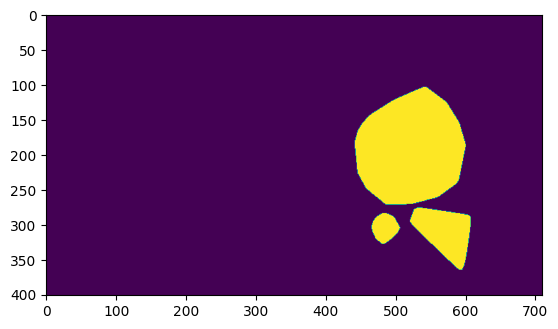

In [20]:
if __name__ == "__main__":
    c = cm.cycleForChange()
    plt.imshow(c.visual())
    print(cc.rsc.trackedObjectToRealCenter(c))
    if not c.isNewObject:
        print(cc.rsc.trackedObjectLastDistance(c), "mm")
    plt.imshow(cm.buildMiniMap())
    plt.show()